# 大規模CANデータGPU処理ベンチマーク

100万、1億、100億メッセージの大規模データでGPU処理性能を評価します。

## 1. 環境設定とインポート

In [1]:
import numpy as np
import pandas as pd
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import gc
import psutil
from gpu_can_decoder import GPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# System info
print("Environment setup complete")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")
print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")

# GPU info
import cupy as cp
mempool = cp.get_default_memory_pool()
print(f"\nGPU Memory Pool:")
print(f"  Used: {mempool.used_bytes() / (1024**3):.2f} GB")
print(f"  Total: {mempool.total_bytes() / (1024**3):.2f} GB")

Environment setup complete
Available RAM: 50.2 GB
Total RAM: 62.8 GB

GPU Memory Pool:
  Used: 0.00 GB
  Total: 0.00 GB


## 2. 大規模データ生成関数

In [2]:
def generate_synthetic_can_data_chunked(n_messages, chunk_size=10_000_000):
    """大規模CANデータの生成（チャンク処理版）"""
    # リアルなCANデータ分布
    address_distribution = {
        170: 0.037,  # 4輪速度
        37: 0.037,   # ステアリング
        36: 0.037,
        740: 0.044,
        608: 0.022,
        180: 0.018,
    }
    
    # 全体の配列を事前割り当て
    timestamps = np.empty(n_messages, dtype=np.float64)
    addresses = np.empty(n_messages, dtype=np.int64)
    data_bytes = np.empty((n_messages, 8), dtype=np.uint8)
    
    # チャンクごとに処理
    n_chunks = (n_messages + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(n_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, n_messages)
        chunk_messages = end_idx - start_idx
        
        # アドレスを生成
        chunk_addresses = []
        for addr, prob in address_distribution.items():
            count = int(chunk_messages * prob)
            chunk_addresses.extend([addr] * count)
        
        # 残りはランダムなアドレス
        remaining = chunk_messages - len(chunk_addresses)
        other_addresses = np.random.choice([452, 466, 467, 705, 321, 562], remaining)
        chunk_addresses.extend(other_addresses)
        
        # シャッフル
        np.random.shuffle(chunk_addresses)
        addresses[start_idx:end_idx] = chunk_addresses[:chunk_messages]
        
        # タイムスタンプ
        timestamps[start_idx:end_idx] = np.linspace(
            46408.0 + (chunk_idx * 60),
            46408.0 + ((chunk_idx + 1) * 60),
            chunk_messages
        )
        
        # データバイト
        chunk_data = np.zeros((chunk_messages, 8), dtype=np.uint8)
        
        for i in range(chunk_messages):
            if addresses[start_idx + i] == 170:  # 4輪速度
                # OpenPilot DBC: (0.01,-67.67) "kph" for Toyota RAV4
                for j in range(4):
                    speed_kmh = np.random.uniform(55, 65)  # 55-65 km/h
                    raw_value = int((speed_kmh + 67.67) / 0.01)
                    chunk_data[i, j*2] = (raw_value >> 8) & 0xFF
                    chunk_data[i, j*2 + 1] = raw_value & 0xFF
            elif addresses[start_idx + i] == 37:  # ステアリング
                chunk_data[i] = [0x00, 0x00, 0x10, 0x00, 0xC0, 0x00, 0x00, 0xFD]
            else:
                chunk_data[i] = np.random.randint(0, 256, 8, dtype=np.uint8)
        
        data_bytes[start_idx:end_idx] = chunk_data
        
        if chunk_idx % 10 == 0:
            print(f"  Generated chunk {chunk_idx + 1}/{n_chunks}")
            gc.collect()
    
    return timestamps, addresses, data_bytes

# テスト
print("Testing data generation...")
test_t, test_a, test_d = generate_synthetic_can_data_chunked(100_000)
print(f"Generated {len(test_t):,} messages")
print(f"Memory usage: {(test_t.nbytes + test_a.nbytes + test_d.nbytes) / (1024**2):.1f} MB")

Testing data generation...
  Generated chunk 1/1
Generated 100,000 messages
Memory usage: 2.3 MB


## 3. 大規模ベンチマーク実行

In [3]:
# デコーダーの初期化（大きめのバッチサイズ）
gpu_decoder = GPUCANDecoder(batch_size=10_000_000)

# テストサイズ
test_sizes = [1_000_000, 100_000_000, 10_000_000_000]
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n{'='*60}")
    print(f"Testing with {n_messages:,} messages")
    print(f"{'='*60}")
    
    # メモリチェック
    required_memory_gb = (n_messages * (8 + 8 + 8*1)) / (1024**3)  # timestamps + addresses + data_bytes
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    
    print(f"Required memory: ~{required_memory_gb:.1f} GB")
    print(f"Available memory: {available_memory_gb:.1f} GB")
    
    if required_memory_gb > available_memory_gb * 0.8:  # 80%以上使用する場合は警告
        print("WARNING: May not have enough memory. Proceeding with caution...")
    
    try:
        # データ生成
        print("\nGenerating synthetic data...")
        gen_start = time.time()
        timestamps, addresses, data_bytes = generate_synthetic_can_data_chunked(n_messages)
        gen_time = time.time() - gen_start
        
        data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
        print(f"Data generation time: {gen_time:.2f} seconds")
        print(f"Data size: {data_size_mb:.1f} MB ({data_size_mb/1024:.2f} GB)")
        
        # GPU処理
        print("\nRunning GPU processing...")
        gpu_start = time.time()
        
        # メモリプールをクリア
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
        
        gpu_results = gpu_decoder.decode_batch(timestamps, addresses, data_bytes)
        cp.cuda.Stream.null.synchronize()  # GPU同期
        gpu_time = time.time() - gpu_start
        
        # 結果の統計
        n_decoded = sum(len(df) for df in gpu_results.values() if df is not None)
        
        # CPU処理時間の推定（線形スケーリング）
        # 100万メッセージで約0.45秒という前回の結果から推定
        estimated_cpu_time = 0.45 * (n_messages / 1_000_000)
        
        # 結果記録
        result = {
            'n_messages': n_messages,
            'data_size_gb': data_size_mb / 1024,
            'generation_time': gen_time,
            'gpu_time': gpu_time,
            'estimated_cpu_time': estimated_cpu_time,
            'speedup': estimated_cpu_time / gpu_time,
            'gpu_throughput_mmsg': n_messages / gpu_time / 1e6,
            'gpu_throughput_gb': (data_size_mb / 1024) / gpu_time,
            'n_decoded_messages': n_decoded
        }
        benchmark_results.append(result)
        
        print(f"\n=== Results ===")
        print(f"GPU processing time: {gpu_time:.3f} seconds")
        print(f"Throughput: {result['gpu_throughput_mmsg']:.1f} Mmessages/sec")
        print(f"Throughput: {result['gpu_throughput_gb']:.2f} GB/sec")
        print(f"Estimated speedup vs CPU: {result['speedup']:.1f}x")
        print(f"Decoded messages: {n_decoded:,}")
        
        # メモリクリーンアップ
        del timestamps, addresses, data_bytes, gpu_results
        gc.collect()
        mempool.free_all_blocks()
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        print("Skipping this test size...")
        continue

# 結果をDataFrameに
if benchmark_results:
    benchmark_df = pd.DataFrame(benchmark_results)
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(benchmark_df.to_string(index=False))


Testing with 1,000,000 messages
Required memory: ~0.0 GB
Available memory: 50.1 GB

Generating synthetic data...
  Generated chunk 1/1
Data generation time: 6.33 seconds
Data size: 22.9 MB (0.02 GB)

Running GPU processing...

=== Results ===
GPU processing time: 0.324 seconds
Throughput: 3.1 Mmessages/sec
Throughput: 0.07 GB/sec
Estimated speedup vs CPU: 1.4x
Decoded messages: 111,000

Testing with 100,000,000 messages
Required memory: ~2.2 GB
Available memory: 50.0 GB

Generating synthetic data...
  Generated chunk 1/10
Data generation time: 653.94 seconds
Data size: 2288.8 MB (2.24 GB)

Running GPU processing...

ERROR: std::bad_alloc: out_of_memory: RMM failure at:/home/ubuntu/miniconda3/envs/cudf_dev/include/rmm/mr/device/pool_memory_resource.hpp:262: Maximum pool size exceeded (failed to allocate 762.939453 MiB): Not enough room to grow, current/max/try size = 1.745058 GiB, 2.000000 GiB, 762.939453 MiB
Skipping this test size...

Testing with 10,000,000,000 messages
Required mem

[1205541][16:52:16:408871][error ] [A][Stream 0x1][Upstream 800000000B][FAILURE maximum pool size exceeded: Not enough room to grow, current/max/try size = 1.745058 GiB, 2.000000 GiB, 762.939453 MiB]


## 4. 結果の可視化

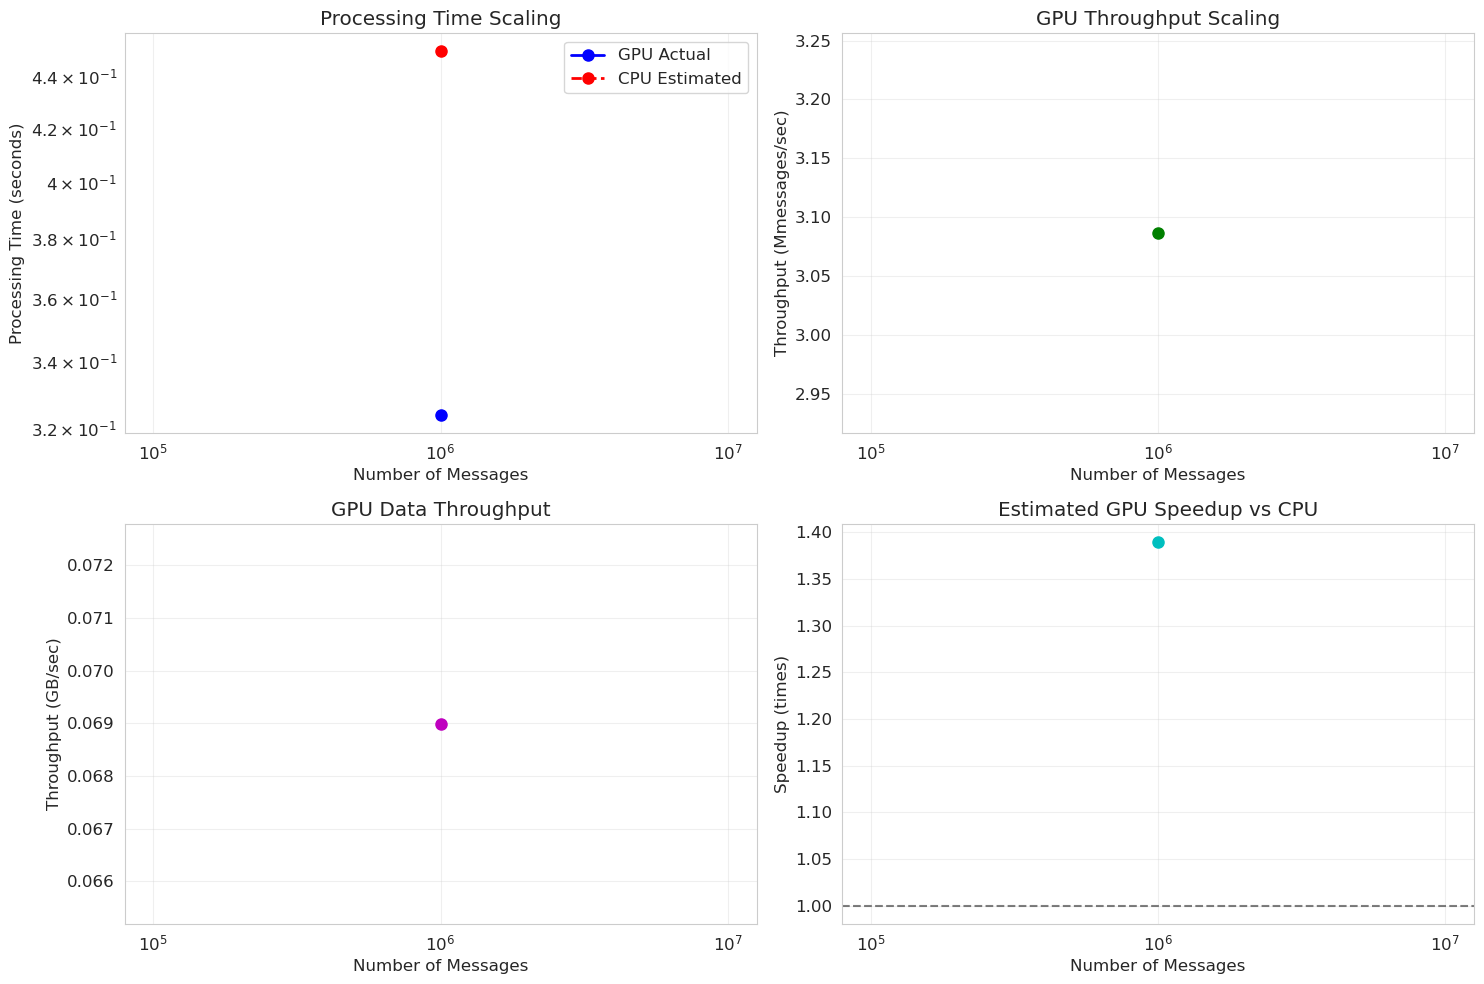


=== Performance Summary ===
Maximum throughput: 3.1 Mmessages/sec
Maximum data rate: 0.07 GB/sec
Maximum speedup: 1.4x


In [4]:
if benchmark_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Processing time vs data size
    ax1.plot(benchmark_df['n_messages'], benchmark_df['gpu_time'], 'b-o', 
             label='GPU Actual', linewidth=2, markersize=8)
    ax1.plot(benchmark_df['n_messages'], benchmark_df['estimated_cpu_time'], 'r--o', 
             label='CPU Estimated', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Messages')
    ax1.set_ylabel('Processing Time (seconds)')
    ax1.set_title('Processing Time Scaling')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Throughput scaling
    ax2.plot(benchmark_df['n_messages'], benchmark_df['gpu_throughput_mmsg'], 'g-o', 
             linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Messages')
    ax2.set_ylabel('Throughput (Mmessages/sec)')
    ax2.set_title('GPU Throughput Scaling')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Data throughput (GB/s)
    ax3.plot(benchmark_df['n_messages'], benchmark_df['gpu_throughput_gb'], 'm-o', 
             linewidth=2, markersize=8)
    ax3.set_xlabel('Number of Messages')
    ax3.set_ylabel('Throughput (GB/sec)')
    ax3.set_title('GPU Data Throughput')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Speedup ratio
    ax4.plot(benchmark_df['n_messages'], benchmark_df['speedup'], 'c-o', 
             linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Messages')
    ax4.set_ylabel('Speedup (times)')
    ax4.set_title('Estimated GPU Speedup vs CPU')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n=== Performance Summary ===")
    print(f"Maximum throughput: {benchmark_df['gpu_throughput_mmsg'].max():.1f} Mmessages/sec")
    print(f"Maximum data rate: {benchmark_df['gpu_throughput_gb'].max():.2f} GB/sec")
    print(f"Maximum speedup: {benchmark_df['speedup'].max():.1f}x")

## 5. メモリ使用量分析

In [5]:
# メモリ使用量の理論値計算
print("=== Memory Usage Analysis ===")
print("\nPer-message memory requirements:")
print("  - Timestamp: 8 bytes (float64)")
print("  - Address: 8 bytes (int64)")
print("  - Data: 8 bytes (8 x uint8)")
print("  - Total: 24 bytes/message")
print("\nDataset sizes:")

for n_messages in test_sizes:
    total_gb = (n_messages * 24) / (1024**3)
    print(f"  - {n_messages:,} messages: {total_gb:.2f} GB")

# GPU メモリ情報
print("\nGPU Memory Status:")
mempool = cp.get_default_memory_pool()
print(f"  - Used: {mempool.used_bytes() / (1024**3):.2f} GB")
print(f"  - Total allocated: {mempool.total_bytes() / (1024**3):.2f} GB")

# GPUデバイス情報
device = cp.cuda.Device()
print(f"\nGPU Device Info:")
print(f"  - Name: {device.name}")
print(f"  - Total Memory: {device.mem_info[1] / (1024**3):.1f} GB")
print(f"  - Free Memory: {device.mem_info[0] / (1024**3):.1f} GB")

=== Memory Usage Analysis ===

Per-message memory requirements:
  - Timestamp: 8 bytes (float64)
  - Address: 8 bytes (int64)
  - Data: 8 bytes (8 x uint8)
  - Total: 24 bytes/message

Dataset sizes:
  - 1,000,000 messages: 0.02 GB
  - 100,000,000 messages: 2.24 GB
  - 10,000,000,000 messages: 223.52 GB

GPU Memory Status:
  - Used: 0.00 GB
  - Total allocated: 0.00 GB

GPU Device Info:


AttributeError: 'cupy.cuda.device.Device' object has no attribute 'name'